<a href="https://colab.research.google.com/github/m-aliabbas/Pneumonia-Train-Models-/blob/master/ChexNet1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from fastai.vision import *
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [0]:
from zipfile import ZipFile 
def unZip(file_name):
  with ZipFile(file_name, 'r') as zip: 
      zip.extractall() 
      print('Done!') 

In [0]:
file_name = '/content/drive/chestXRay.zip'

In [0]:
path="/content/drive/My Drive/"
file_name=path+'chestXRay.zip'

In [0]:
unZip(file_name)

Done!


In [0]:
unZip('chest_xray.zip')

Done!


In [0]:
import glob
import cv2
import numpy as np
%matplotlib inline
filesPos= sorted(glob.glob('chest_xray/train/NORMAL/*.jpeg'))
filesPos+=sorted(glob.glob('chest_xray/val/NORMAL/*.jpeg'))
filesPos+=sorted(glob.glob('chest_xray/test/NORMAL/*.jpeg'))



In [0]:
filesNeg=sorted(glob.glob('chest_xray/train/PNEUMONIA/*.jpeg'))
filesNeg+=sorted(glob.glob('chest_xray/val/PNEUMONIA/*.jpeg'))
filesNeg+=sorted(glob.glob('chest_xray/test/PNEUMONIA/*.jpeg'))

In [0]:
random.shuffle(filesNeg)
len(filesPos),len(filesNeg)

(1583, 4273)

In [0]:
filesNeg=filesNeg[:2100]

In [0]:
pos_labels=[[i,0] for i in filesPos]
neg_labels=[[i,1] for i in filesNeg]
ds=pos_labels+neg_labels

In [0]:
np.random.seed(4200)
import pandas as pd 
df = pd.DataFrame(ds,columns =['path', 'label']) 
def Randomizing(df):
    df2 = df.reindex(np.random.permutation(df.index))
    return df2
df=Randomizing(df)

In [0]:
from sklearn.model_selection import train_test_split
dfTrain,dfTest=train_test_split(df, shuffle=False,test_size=0.1, random_state=42)

In [0]:
len(dfTrain),len(dfTest)

(3314, 369)

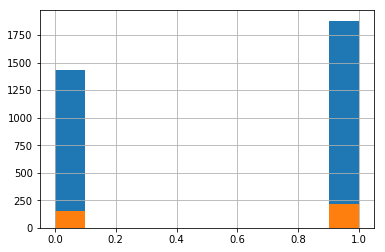

In [0]:
dfTrain['label'].hist()
dfTest['label'].hist()

In [0]:
bs =8
sz=224
tfms = get_transforms(do_flip=True,flip_vert=True,max_lighting=0.4,max_zoom=1.1)
src = (ImageList.from_df(df=dfTrain,path='',cols='path') #get dataset from dataset
        .split_by_rand_pct(0.2) #Splitting the dataset
        .label_from_df(cols='label') #obtain labels from the level column
      )
data= (src.transform(tfms,size=224,padding_mode='zeros') #Data augmentation
        .databunch(bs=bs,num_workers=4) #DataBunch
        .normalize(imagenet_stats) #Normalize     
       )

In [0]:
data.classes

[0, 1]

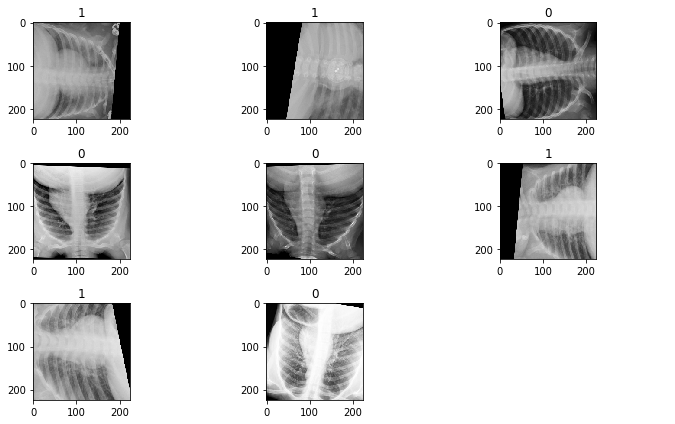

In [0]:
data.show_batch(rows=3, figsize=(10,6), hide_axis=False)

In [0]:
from sklearn.metrics import roc_auc_score,f1_score
def f1_score_a(y_pred,y_true,tens=True):
#     score=roc_auc_score(y_true,torch.sigmoid(y_pred)[:,1])
    f1a_score=f1_score(y_true, np.round(torch.sigmoid(y_pred)[:,1]), average='macro') 
    if tens:
#         score=tensor(score)
        f1a_score=tensor(f1a_score)
    else:
        f1a_score=f1a_score
    return f1a_score


In [0]:

import torch 
import torchvision


In [0]:
!git clone https://github.com/zoogzog/chexnet.git

fatal: destination path 'chexnet' already exists and is not an empty directory.


In [0]:
!ls chexnet/models

m-25012018-123527.pth.tar


In [0]:
!ls 

chest_xray	chexnet		 drive	      __MACOSX	sample_data
chest_xray.zip	CheXNet-Pytorch  history.csv  models


In [0]:
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


In [0]:
CKPT_PATH = 'chexnet/models/m-25012018-123527.pth.tar'
cudnn.benchmark = True

In [0]:
class DenseNet121(nn.Module):

    def __init__(self, classCount, isTrained):
	
        super(DenseNet121, self).__init__()
		
        self.densenet121 = torchvision.models.densenet121(pretrained=isTrained)

        kernelCount = self.densenet121.classifier.in_features
		
        self.densenet121.classifier = nn.Sequential(nn.Linear(kernelCount, classCount), nn.Sigmoid())

    def forward(self, x):
        x = self.densenet121(x)
        return x

In [0]:
model=DenseNet121(14,False)

In [0]:
print(torch.__version__)

1.1.0


In [0]:
net = torch.nn.DataParallel(model)

In [0]:
cudnn.benchmark = True

In [0]:
ckpt=torch.load(CKPT_PATH)["state_dict"]
new_state_dict = collections.OrderedDict() 
for k, v in ckpt.items(): 
   name = k.replace('module.', '') # remove `module.`
   new_state_dict[name] = v
new_state_dict1 = collections.OrderedDict() 
new_key=""

for (k,v)  in new_state_dict.items():
      old_key=k
      klist=k.split('.')
      for _ in klist:
          if(_.isdigit()):
            ind=klist.index(_)
            klist[ind-1]=klist[ind-1]+_
            klist.remove(_)
            seperator = '.'
            new_key=seperator.join(klist)
            old_key = k.replace(old_key, new_key)
            # print(old_key)
      new_state_dict1[old_key] = v
           
            


In [0]:
print(new_state_dict1.keys())

odict_keys(['densenet121.features.conv0.weight', 'densenet121.features.norm0.weight', 'densenet121.features.norm0.bias', 'densenet121.features.norm0.running_mean', 'densenet121.features.norm0.running_var', 'densenet121.features.denseblock1.denselayer1.norm1.weight', 'densenet121.features.denseblock1.denselayer1.norm1.bias', 'densenet121.features.denseblock1.denselayer1.norm1.running_mean', 'densenet121.features.denseblock1.denselayer1.norm1.running_var', 'densenet121.features.denseblock1.denselayer1.conv1.weight', 'densenet121.features.denseblock1.denselayer1.norm2.weight', 'densenet121.features.denseblock1.denselayer1.norm2.bias', 'densenet121.features.denseblock1.denselayer1.norm2.running_mean', 'densenet121.features.denseblock1.denselayer1.norm2.running_var', 'densenet121.features.denseblock1.denselayer1.conv2.weight', 'densenet121.features.denseblock1.denselayer2.norm1.weight', 'densenet121.features.denseblock1.denselayer2.norm1.bias', 'densenet121.features.denseblock1.denselayer2.

In [0]:
new_state_dict1["densenet121.classifier.0.weight"] = new_state_dict1.pop("densenet121.classifier0.weight")

In [0]:
new_state_dict1["densenet121.classifier.0.bias"] = new_state_dict1.pop("densenet121.classifier0.bias")

In [0]:
model.load_state_dict(new_state_dict1)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
model=model.cuda()

In [0]:
from fastai.callbacks import *

learn = Learner(data, model, metrics=[error_rate, accuracy,f1_score_a],callback_fns=[partial(CSVLogger,append=True),BnFreeze, partial(GradientClipping, clip=0.3)])

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.51E-03
Min loss divided by 10: 3.31E-01


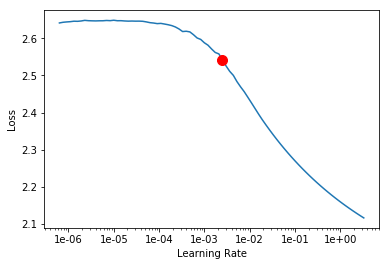

In [0]:
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr  if hasattr(learn, 'recorder') else 1e-2


In [0]:
from fastai.callbacks import *
learn.fit_one_cycle(14,min_grad_lr,callbacks=[SaveModelCallback(learn, every='imrpovement', monitor='f1_score_a')])

/usr/local/lib/python3.6/dist-packages/fastai/callbacks/tracker.py:83: UserWarning: SaveModel every imrpovement is invalid, falling back to "improvement".
  warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')


epoch,train_loss,valid_loss,error_rate,accuracy,f1_score_a,time
0,1.854356,1.813344,0.078550,0.921450,0.355727,02:48
1,1.862974,1.844430,0.188822,0.811178,0.355727,02:47
2,1.857283,1.831265,0.166163,0.833837,0.355727,02:47
3,1.863097,1.941484,0.321752,0.678248,0.355727,02:47
4,1.858608,1.858570,0.566465,0.433535,0.355727,02:46
5,1.858573,1.858569,0.551360,0.448640,0.355727,02:46
6,1.858573,1.858569,0.280967,0.719033,0.355727,02:46
7,1.858573,1.858569,0.454683,0.545317,0.355727,02:47
8,1.858573,1.858569,0.533233,0.466767,0.355727,02:47
9,1.858573,1.858569,0.560423,0.439577,0.355727,02:47


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Better model found at epoch 0 with f1_score_a value: 0.35572710633277893.


In [0]:
learn.load('bestmodel');

/usr/local/lib/python3.6/dist-packages/fastai/callbacks/tracker.py:83: UserWarning: SaveModel every imrpovement is invalid, falling back to "improvement".
  warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')


epoch,train_loss,valid_loss,error_rate,accuracy,f1_score_a,time
0,1.816950,1.813870,0.080060,0.919940,0.696158,02:48
1,1.813904,1.786669,0.042296,0.957704,0.604081,02:48
2,1.806178,1.779800,0.030211,0.969788,0.707605,02:48
3,1.801570,1.790612,0.049849,0.950151,0.726637,02:48
4,1.798917,1.784023,0.030211,0.969788,0.360154,02:48
5,1.804289,1.778153,0.037764,0.962236,0.380458,02:48
6,1.800348,1.790697,0.051360,0.948640,0.355727,02:48
7,1.800862,1.800969,0.057402,0.942598,0.355727,02:48
8,1.794404,1.778166,0.027190,0.972810,0.357722,02:47
9,1.787270,1.779383,0.039275,0.960725,0.355727,02:47


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Better model found at epoch 0 with f1_score_a value: 0.6961575746536255.
Better model found at epoch 2 with f1_score_a value: 0.7076051831245422.
Better model found at epoch 3 with f1_score_a value: 0.726637065410614.


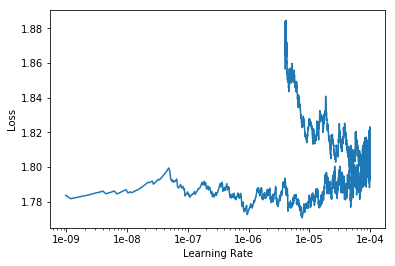

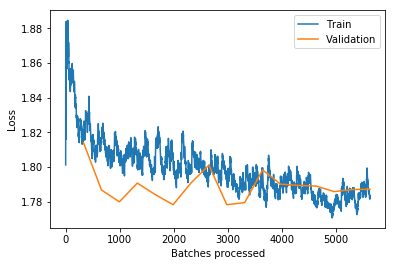

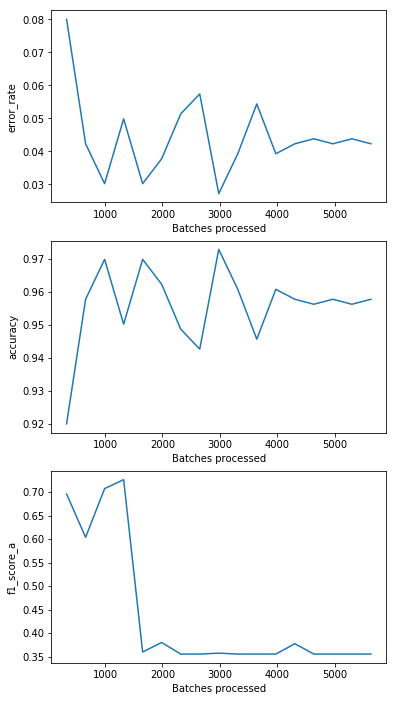

In [44]:

learn.unfreeze()
learn.fit_one_cycle(17,1e-04,callbacks=[SaveModelCallback(learn, every='imrpovement', monitor='f1_score_a')])
learn.recorder.plot()
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

Precision of Model = 0.9312169312169312 Recall of Model  0.9805013927576601
F1 Score of Model = 0.955223880597015


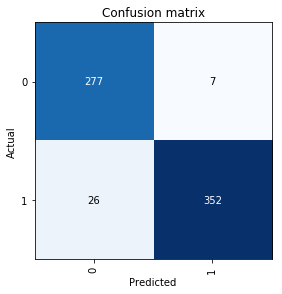

In [45]:
learn.load('bestmodel')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
conf=interp.confusion_matrix()
TrueNagitive=conf[0][0]
FalseNegative=conf[0][1]
TruePositive=conf[1][1]
FalsePositive=conf[1][0]
recal=TruePositive/(TruePositive+FalseNegative)
precision=TruePositive/(TruePositive+FalsePositive)
print("Precision of Model =",precision,"Recall of Model ", recal)
f1=2*((precision*recal)/(precision+recal))
print('F1 Score of Model =',f1)

In [0]:
bs =8
sz=224
tfms = get_transforms(do_flip=True,flip_vert=True,max_lighting=0.4,max_zoom=1.1)
src = (ImageList.from_df(df=dfTest,path='',cols='path') #get dataset from dataset
        .split_by_rand_pct(0.0) #Splitting the dataset
        .label_from_df(cols='label') #obtain labels from the level column
      )
dataTest= (src.transform(tfms,size=224,padding_mode='zeros') #Data augmentation
        .databunch(bs=bs,num_workers=4) #DataBunch
        .normalize(imagenet_stats) #Normalize     
       )

In [0]:
learn.data.valid_dl = dataTest.train_dl

In [48]:
learn.validate()

[1.8047396, tensor(0.0543), tensor(0.9457), tensor(0.5159)]

Precision of Model = 0.954337899543379 Recall of Model  0.9675925925925926
F1 Score of Model = 0.960919540229885


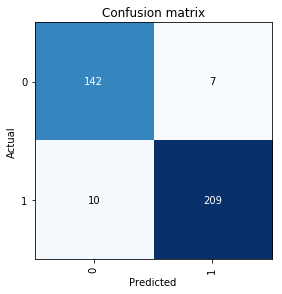

In [49]:
learn.load('bestmodel')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
conf=interp.confusion_matrix()
TrueNagitive=conf[0][0]
FalseNegative=conf[0][1]
TruePositive=conf[1][1]
FalsePositive=conf[1][0]
recal=TruePositive/(TruePositive+FalseNegative)
precision=TruePositive/(TruePositive+FalsePositive)
print("Precision of Model =",precision,"Recall of Model ", recal)
f1=2*((precision*recal)/(precision+recal))
print('F1 Score of Model =',f1)

In [50]:
!ls

chest_xray	chexnet		 drive	      __MACOSX	sample_data
chest_xray.zip	CheXNet-Pytorch  history.csv  models


In [51]:
!mkdir '/content/drive/My Drive/Res18LRPne1'
!cp 'models/bestmodel.pth' '/content/drive/My Drive/Res18LRPne1'
!cp 'history.csv' '/content/drive/My Drive/Res18LRPne1'

mkdir: cannot create directory ‘/content/drive/My Drive/Res18LRPne1’: File exists
